In [6]:
import os
import glob
import numpy as np
import nibabel as nib
import json
from scipy.ndimage import binary_erosion, generate_binary_structure, rotate
from skimage.transform import downscale_local_mean
import time

# ==========================================
# 1. CONFIGURACIÓN MASIVA (nnU-Net v2)
# ==========================================
# Ruta origen (AIBL limpio)
INPUT_ROOT_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/CSIRO_dataset/NoCMBSubject/data"

# Ruta destino: IMPORTANTE usar formato DatasetXXX_Nombre
DATASET_NAME = "Dataset111_SyntheticCMB"
NNUNET_RAW_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/nnUNet_raw" 
OUTPUT_DIR = os.path.join(NNUNET_RAW_DIR, DATASET_NAME)

# Parámetros
NUM_LESIONS_PER_SCAN = 20
RANDOM_SEED = 42

# Crear estructura de carpetas nnU-Net v2
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(os.path.join(OUTPUT_DIR, "imagesTr"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "labelsTr"), exist_ok=True)

# ==========================================
# 2. MOTOR MATEMÁTICO (Momeni Validado)
# ==========================================
def generate_momeni_gaussian(target_volume_mm3, voxel_size_mm, oversample=10):
    K = 1.175 
    term = (3 * target_volume_mm3) / (4 * np.pi * (K**3))
    sigma_t_mm = np.cbrt(term)
    
    rmin, rmax = 0.5, 0.9
    sigma_x_mm = sigma_t_mm * ((rmax - rmin) * np.random.uniform(0, 1) + rmin)
    sigma_y_mm = sigma_t_mm * ((rmax - rmin) * np.random.uniform(0, 1) + rmin)
    sigma_z_mm = (sigma_t_mm**3) / (sigma_x_mm * sigma_y_mm)
    
    hr_vx_size = np.array(voxel_size_mm) / oversample
    sx_px = sigma_x_mm / hr_vx_size[0]
    sy_px = sigma_y_mm / hr_vx_size[1]
    sz_px = sigma_z_mm / hr_vx_size[2]
    
    max_sigma = max(sx_px, sy_px, sz_px)
    grid_size = int(max_sigma * 6) + 1
    if grid_size % 2 == 0: grid_size += 1
    
    cx, cy, cz = grid_size // 2, grid_size // 2, grid_size // 2
    
    x = np.arange(grid_size) - cx
    y = np.arange(grid_size) - cy
    z = np.arange(grid_size) - cz
    xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
    
    exponent = - ( (xx**2)/(2*sx_px**2) + (yy**2)/(2*sy_px**2) + (zz**2)/(2*sz_px**2) )
    gaussian = np.exp(exponent)
    
    angle_x = np.random.uniform(-30, 30)
    angle_y = np.random.uniform(-30, 30)
    angle_z = np.random.uniform(-30, 30)
    
    img_rot = rotate(gaussian, angle_x, axes=(0,1), reshape=False, order=1)
    img_rot = rotate(img_rot, angle_y, axes=(1,2), reshape=False, order=1)
    img_rot = rotate(img_rot, angle_z, axes=(0,2), reshape=False, order=1)
    
    low_res_blob = downscale_local_mean(img_rot, (oversample, oversample, oversample))
    if low_res_blob.max() > 0:
        low_res_blob /= low_res_blob.max()
        
    return low_res_blob

# INTRODUCIMOS MULTI OTSU PARA OBTENER ÁREA VÁLIDA CEREBRAL PARA sCMB

def get_brain_safety_mask_robust(img_data, erosion_iters=5):
    """
    Usa Multi-Otsu para calcular dinámicamente el umbral de tejido.
    Evita pintar en ventrículos (líquido) o fondo.
    """
    # Aplanamos y quitamos ceros para calcular el umbral
    data_vector = img_data[img_data > 10].ravel()
    
    try:
        if len(data_vector) < 1000:
            raise ValueError("Imagen vacía")
            
        # 3 Clases: Fondo(0) | Líquido(1) | Tejido(2)
        thresholds = threshold_multiotsu(data_vector, classes=3)
        tissue_threshold = thresholds[1] # Corte Líquido vs Tejido
        
    except Exception:
        # Fallback de seguridad: Media simple si Otsu falla
        tissue_threshold = np.mean(data_vector) if len(data_vector) > 0 else 20
        print(f"   [!] Fallback Threshold: {tissue_threshold:.2f}")

    # Binarizar con el umbral inteligente
    binary = img_data > tissue_threshold
    
    # Erosión: Alejarse de los bordes (Cráneo y Ventrículos)
    struct = generate_binary_structure(3, 1) 
    eroded = binary_erosion(binary, structure=struct, iterations=erosion_iters)
    
    return eroded, tissue_threshold


def implant_and_label(image_data, label_data, center, volume_mm3, voxel_dims, strength):
    x, y, z = center
    lesion_pattern = generate_momeni_gaussian(volume_mm3, voxel_dims, oversample=10)
    
    p_shape = lesion_pattern.shape
    dx, dy, dz = p_shape[0]//2, p_shape[1]//2, p_shape[2]//2
    x_s, x_e = x - dx, x - dx + p_shape[0]
    y_s, y_e = y - dy, y - dy + p_shape[1]
    z_s, z_e = z - dz, z - dz + p_shape[2]
    
    if x_s < 0 or x_e > image_data.shape[0] or \
       y_s < 0 or y_e > image_data.shape[1] or \
       z_s < 0 or z_e > image_data.shape[2]:
        return image_data, label_data
    
    roi_img = image_data[x_s:x_e, y_s:y_e, z_s:z_e]
    if roi_img.shape != lesion_pattern.shape:
        lesion_pattern = lesion_pattern[:roi_img.shape[0], :roi_img.shape[1], :roi_img.shape[2]]
        
    mask_multiplier = 1 - (lesion_pattern * strength)
    image_data[x_s:x_e, y_s:y_e, z_s:z_e] = roi_img * mask_multiplier
    
    roi_label = label_data[x_s:x_e, y_s:y_e, z_s:z_e]
    lesion_mask_binary = (lesion_pattern >= 0.5).astype(int)
    label_data[x_s:x_e, y_s:y_e, z_s:z_e] = np.maximum(roi_label, lesion_mask_binary)
    
    return image_data, label_data

# ==========================================
# 3. EJECUCIÓN DEL PIPELINE MASIVO
# ==========================================
print(f"Iniciando Pipeline Masivo...")
nifti_files = glob.glob(os.path.join(INPUT_ROOT_DIR, "**/*.nii.gz"), recursive=True)
print(f"Archivos encontrados: {len(nifti_files)}")

np.random.seed(RANDOM_SEED)

# Contador para el dataset.json
train_files_count = 0

for idx, file_path in enumerate(nifti_files):
    start_time = time.time()
    filename = os.path.basename(file_path)
    # ID simple para nnU-Net: CSIRO_001, CSIRO_002...
    subject_id = f"CSIRO_{idx+1:03d}" 
    
    print(f"\n[{idx+1}/{len(nifti_files)}] {filename} -> {subject_id}")
    
    try:
        nii = nib.load(file_path)
        data_img = nii.get_fdata().astype(float)
        data_label = np.zeros(data_img.shape, dtype=np.uint8)
        voxel_dims = nii.header.get_zooms()

        safety_mask, used_thresh = get_brain_safety_mask_robust(data_img)
        valid_coords = np.argwhere(safety_mask)
        
        print(f"   -> Umbral calculado: {used_thresh:.2f} | Vóxeles seguros: {len(valid_coords)}")
        
        if len(valid_coords) < NUM_LESIONS_PER_SCAN:
            print(f"SKIP: Pocos vóxeles seguros tras umbral estricto.")
            continue
            
        random_indices = np.random.choice(len(valid_coords), size=NUM_LESIONS_PER_SCAN, replace=False)
        selected_coords = valid_coords[random_indices]
        
        for coord in selected_coords:
            # Distribución Triangular:
            # - Mínimo: 0.8 mm3 (aprox 1.1 mm diámetro) -> Puntos finos
            # - Moda:   2.5 mm3 (aprox 1.7 mm diámetro) -> La mayoría serán así
            # - Máximo: 15.0 mm3 (aprox 3.1 mm diámetro) -> El límite superior, pero poco frecuente
            vol_rnd = np.random.triangular(left=0.8, mode=2.5, right=15.0)
            #vol_rnd = np.random.uniform(0.8, 15.0)
            str_rnd = np.random.uniform(0.85, 1.0)
            data_img, data_label = implant_and_label(data_img, data_label, coord, vol_rnd, voxel_dims, str_rnd)
            
        # --- GUARDADO NNUNET ---
        out_name_img = f"{subject_id}_0000.nii.gz" # Canal 0
        out_name_lbl = f"{subject_id}.nii.gz"      # Label
        
        path_img = os.path.join(OUTPUT_DIR, "imagesTr", out_name_img)
        path_lbl = os.path.join(OUTPUT_DIR, "labelsTr", out_name_lbl)
        
        nib.save(nib.Nifti1Image(data_img, nii.affine, nii.header), path_img)
        nib.save(nib.Nifti1Image(data_label, nii.affine, nii.header), path_lbl)
        
        train_files_count += 1
        elapsed = time.time() - start_time
        print(f"Ok ({elapsed:.2f}s)")
        
    except Exception as e:
        print(f"ERROR: {e}")

# ==========================================
# 4. GENERACIÓN AUTOMÁTICA DATASET.JSON (v2)
# ==========================================
print("-" * 50)
print("Generando dataset.json para nnU-Net v2...")

json_dict = {
    "channel_names": {
        "0": "SWI"  # O la modalidad que sea (T2*, T1, etc.)
    },
    "labels": {
        "background": 0,
        "CMB": 1
    },
    "numTraining": train_files_count,
    "file_ending": ".nii.gz",
    "name": DATASET_NAME,
    "reference": "Synthetic Data generated via Momeni method",
    "release": "1.0",
    "description": "Synthetic Microbleeds dataset for TFM",
    "overwrite_image_reader_writer": "SimpleITKIO"
}

json_path = os.path.join(OUTPUT_DIR, "dataset.json")
with open(json_path, 'w') as f:
    json.dump(json_dict, f, indent=4)

print(f"dataset.json creado en: {json_path}")
print("-" * 50)
print(f"TODO LISTO. Dataset preparado en: {OUTPUT_DIR}")
print(" -> Siguiente paso: nnUNetv2_plan_and_preprocess")

Iniciando Pipeline Masivo...
Archivos encontrados: 313

[1/313] 2_T2_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_001
   -> Umbral calculado: 403.53 | Vóxeles seguros: 18315
Ok (2.27s)

[2/313] 13_T2_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_002
   -> Umbral calculado: 403.53 | Vóxeles seguros: 25945
Ok (1.49s)

[3/313] 13_T3_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_003
   -> Umbral calculado: 403.53 | Vóxeles seguros: 27497
Ok (2.09s)

[4/313] 14_T2_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_004
   -> Umbral calculado: 403.53 | Vóxeles seguros: 33974
Ok (2.23s)

[5/313] 14_T3_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_005
   -> Umbral calculado: 403.53 | Vóxeles seguros: 32589
Ok (2.10s)

[6/313] 14_T4_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_006
   -> Umbral calculado: 403.53 | Vóxeles seguros: 46164
Ok (2.36s)

[7/313] 14_T5_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_007
   -> Umbral calculado: 403.53 | Vóxeles seguros: 41655
Ok (1.94s)

[8/313] 14_T6_MRI_SWI_BFC_50mm_HM.nii.gz -> CSIRO_008
   -> Umbral calculado: 403.53 | Vóxe

Para saber qué umbral usar para asegurarnos de que las sCMBs siempre caigan en áreas válidas:

Cargando imagen: 2_T2_MRI_SWI_BFC_50mm_HM.nii.gz...
Calculando umbrales Multi-Otsu (3 clases)...
----------------------------------------
Umbral 1 (Fondo vs Liquido):  204.50
Umbral 2 (Liquido vs Tejido): 403.53
----------------------------------------


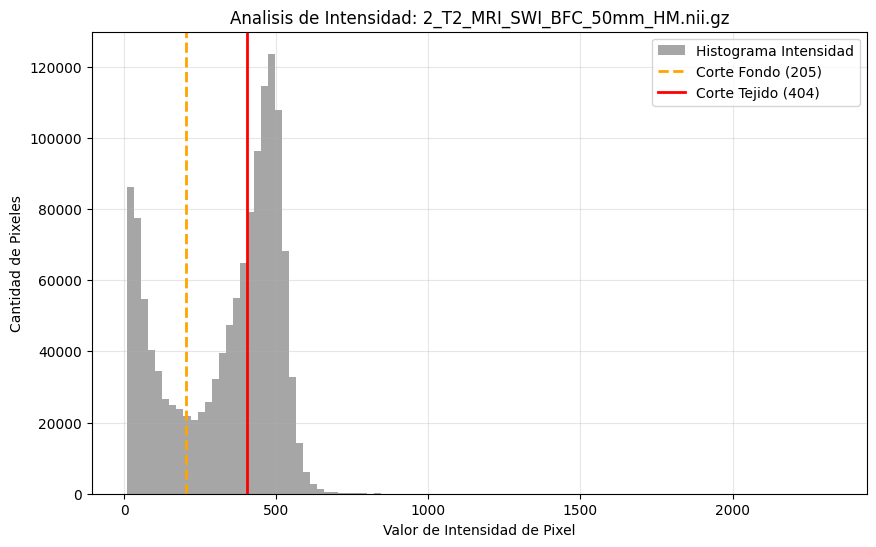

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu

# ================= CONFIGURACION =================
# Imagen ejemplo
FILE_PATH = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/CSIRO_dataset/NoCMBSubject/data/2_T2_MRI_SWI_BFC_50mm_HM.nii.gz" 
# =================================================

def analyze_histogram(nifti_path):
    print(f"Cargando imagen: {os.path.basename(nifti_path)}...")
    nii = nib.load(nifti_path)
    data = nii.get_fdata()
    
    # Aplanamos los datos para el histograma, ignorando el 0 absoluto (fondo)
    # Si no quitamos el 0, el histograma se rompe porque hay millones de pixeles negros
    data_vector = data[data > 10].ravel() 
    
    if len(data_vector) == 0:
        print("Error: La imagen parece vacia o tiene valores muy bajos.")
        return

    print("Calculando umbrales Multi-Otsu (3 clases)...")
    # Pedimos 3 clases: 
    # Clase 0: Ruido de fondo / Aire
    # Clase 1: Liquido Cefalorraquideo (LCR) / Ventriculos
    # Clase 2: Tejido Cerebral (Gris/Blanca)
    try:
        thresholds = threshold_multiotsu(data_vector, classes=3)
        thresh_liq_tejido = thresholds[1] # El segundo umbral separa Liquido de Tejido
    except Exception as e:
        print(f"Error calculando Otsu: {e}")
        return

    print("-" * 40)
    print(f"Umbral 1 (Fondo vs Liquido):  {thresholds[0]:.2f}")
    print(f"Umbral 2 (Liquido vs Tejido): {thresholds[1]:.2f}")
    print("-" * 40)
    
    # --- VISUALIZACION ---
    plt.figure(figsize=(10, 6))
    
    # Pintamos el histograma (frecuencia de pixeles)
    # bins='auto' decide el ancho de las barras automaticamente
    plt.hist(data_vector, bins=100, color='gray', alpha=0.7, label='Histograma Intensidad')
    
    # Pintamos las lineas de corte
    plt.axvline(thresholds[0], color='orange', linestyle='--', linewidth=2, label=f'Corte Fondo ({thresholds[0]:.0f})')
    plt.axvline(thresholds[1], color='red', linestyle='-', linewidth=2, label=f'Corte Tejido ({thresholds[1]:.0f})')
    
    plt.title(f"Analisis de Intensidad: {os.path.basename(nifti_path)}")
    plt.xlabel("Valor de Intensidad de Pixel")
    plt.ylabel("Cantidad de Pixeles")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()

if __name__ == "__main__":
    if os.path.exists(FILE_PATH):
        analyze_histogram(FILE_PATH)
    else:
        print(f"No encuentro el archivo: {FILE_PATH}")

In [5]:
voxel_dims = nii.header.get_zooms()
print(voxel_dims)

(np.float32(0.93749994), np.float32(0.93749994), np.float32(1.7499992))


In [ ]:
import os
import shutil
import glob
import json

# ================= CONFIGURACIÓN =================
# La ruta donde está tu nnUNet_raw
NNUNET_RAW = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/nnUNet_raw"
DATASET_NAME = "Dataset111_SyntheticCMB"
NUM_TEST_FILES = 33  # Cantidad de sujetos a mover al Test Set

# Rutas completas
dataset_dir = os.path.join(NNUNET_RAW, DATASET_NAME)
imagesTr_dir = os.path.join(dataset_dir, "imagesTr")
labelsTr_dir = os.path.join(dataset_dir, "labelsTr")

# Nuevas carpetas de Test (nnU-Net usa Ts para Test)
imagesTs_dir = os.path.join(dataset_dir, "imagesTs")
labelsTs_dir = os.path.join(dataset_dir, "labelsTs")
# =================================================

def split_and_update():
    # 1. Crear carpetas de destino si no existen
    os.makedirs(imagesTs_dir, exist_ok=True)
    os.makedirs(labelsTs_dir, exist_ok=True)
    print(f"Carpetas de test creadas en: {dataset_dir}")

    # 2. Listar todos los archivos de entrenamiento
    # Buscamos por imágenes, ordenamos para que siempre sean los últimos
    print("🔍 Buscando archivos...")
    all_images = sorted(glob.glob(os.path.join(imagesTr_dir, "*.nii.gz")))
    
    total_files = len(all_images)
    if total_files == 0:
        print("Error: No hay archivos en imagesTr. ¿Has generado el dataset?")
        return

    # Seleccionar los últimos N archivos
    files_to_move = all_images[-NUM_TEST_FILES:]
    files_remaining = all_images[:-NUM_TEST_FILES]

    print(f"Total encontrados: {total_files}")
    print(f"Moviendo {len(files_to_move)} archivos a Test Set...")
    print(f"Quedarán {len(files_remaining)} para Entrenamiento.")

    # 3. Mover archivos
    count = 0
    for img_path in files_to_move:
        filename_img = os.path.basename(img_path)
        
        # El nombre del archivo de imagen es: CSIRO_XXX_0000.nii.gz
        # El nombre del label correspondiente es: CSIRO_XXX.nii.gz
        # Hay que reconstruir el nombre del label
        case_id = filename_img.replace("_0000.nii.gz", "")
        filename_lbl = f"{case_id}.nii.gz"
        
        lbl_path = os.path.join(labelsTr_dir, filename_lbl)

        # Destinos
        dst_img = os.path.join(imagesTs_dir, filename_img)
        dst_lbl = os.path.join(labelsTs_dir, filename_lbl)

        # Mover Imagen
        shutil.move(img_path, dst_img)
        
        # Mover Label (si existe)
        if os.path.exists(lbl_path):
            shutil.move(lbl_path, dst_lbl)
        else:
            print(f"⚠️ Aviso: No encontré label para {case_id}")

        count += 1

    print(f"Movidos {count} sujetos correctamente.")

    # 4. Regenerar dataset.json
    print("Actualizando dataset.json...")
    
    json_path = os.path.join(dataset_dir, "dataset.json")
    
    # Estructura del JSON para nnU-Net v2
    json_dict = {
        "channel_names": {"0": "SWI"},
        "labels": {"background": 0, "CMB": 1},
        "numTraining": len(files_remaining),  # ¡Importante! Actualizamos el número
        "file_ending": ".nii.gz",
        "name": DATASET_NAME,
        "reference": "Synthetic Data via Momeni (Split Train/Test)",
        "release": "2.1",
        "description": "Synthetic Microbleeds dataset with Train/Test split",
        "overwrite_image_reader_writer": "SimpleITKIO"
    }

    with open(json_path, 'w') as f:
        json.dump(json_dict, f, indent=4)

    print("¡Proceso terminado! Ya puedes lanzar el entrenamiento.")
    print(f"   -> Train: {len(files_remaining)} sujetos")
    print(f"   -> Test:  {len(files_to_move)} sujetos")

if __name__ == "__main__":
    split_and_update()

Carpetas de test creadas en: /media/PORT-DISK/Practicas/MicroBleeds_Generation/nnUNet_raw/Dataset111_SyntheticCMB
🔍 Buscando archivos...
Total encontrados: 313
Moviendo 33 archivos a Test Set...
Quedarán 280 para Entrenamiento.
Movidos 33 sujetos correctamente.
Actualizando dataset.json...
🎉 ¡Proceso terminado! Ya puedes lanzar el entrenamiento.
   -> Train: 280 sujetos
   -> Test:  33 sujetos
